In [1]:
from collections import defaultdict
from pydantic import BaseSettings
from pathlib import Path
from typing import Any, Dict, List, Union, Tuple

import os
import glob
import pyproj
import rasterio as rio
import numpy as np
import geopandas as gpd
from tqdm import tqdm
from rasterio.mask import mask as rmask
from shapely import geometry as geom, ops

import tifffile as tif
import json

from rasterio.plot import show
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# setup a few variables and stuff from environment
class NbSettings(BaseSettings):
    class Config:
        env_file = ".env"
        env_file_encoding = "utf-8"
    vector_folder: Path
    delivery_id: str
    masks_folder: Path
    raster_folder: Path
    processed_folder: Path
    window_folder: Path
    data_folder: Path
    class2index: dict = {
        "background": 0,
        "Mono cristallino": 1,
        "Poli cristallino": 2
    }
    index2color: dict = {
        0: (0, 0, 0),
        1: (255, 0, 0),
        2: (0, 255, 0),
        3: (0, 0, 255),
        255: (0, 0, 0)
    }
    index2class: dict = {v: k for k, v in class2index.items()}
    color2index: dict = {v: k for k, v in index2color.items()}
    chip_size: int = 256


In [3]:
settings = NbSettings()
for k, v in settings.dict().items():
    print(f"{k:<20s}: {v}")

vector_folder       : /mnt/data1/datasets/satellite/ithaca/panels
delivery_id         : 22062021
masks_folder        : /mnt/data1/datasets/satellite/ithaca/masks
raster_folder       : /mnt/data1/datasets/satellite/ithaca/ortho/2018
processed_folder    : /mnt/userdata/signoretta_data/solar-panels/tiles-256
window_folder       : /mnt/userdata/signoretta_data/solar-panels/data-tif
data_folder         : /mnt/userdata/signoretta_data/solar-panels/data-detectron2
class2index         : {'background': 0, 'Mono cristallino': 1, 'Poli cristallino': 2}
index2color         : {0: (0, 0, 0), 1: (255, 0, 0), 2: (0, 255, 0), 3: (0, 0, 255), 255: (0, 0, 0)}
index2class         : {0: 'background', 1: 'Mono cristallino', 2: 'Poli cristallino'}
color2index         : {(0, 0, 0): 255, (255, 0, 0): 1, (0, 255, 0): 2, (0, 0, 255): 3}
chip_size           : 256


In [24]:
# retrieve a single shapefile corresponding to a delivery
shapefile_path = glob.glob(str((settings.vector_folder / settings.delivery_id).joinpath("pannelli_fot_all_*.shp")))
assert len(shapefile_path) == 1, "There should be only one shapefile per delivery!"
shapefile_path = shapefile_path[0]
shapefile_path

'/mnt/data1/datasets/satellite/ithaca/panels/22062021/pannelli_fot_all_22062021.shp'

In [25]:
# read data from the shapefile to create a dataframe, containing the geometry information of each panel
dataframe = gpd.read_file(shapefile_path)
dataframe.rename(columns={
    'objectid': "id",
    'id': "plant_id",
    'regione': "region",
    'provincia': "province",
    'tipologia': "type",
    'categoria': "category",
    'orientamen': "orientation",
    'potenza': "power",
    'superficie': "surface",
    'note': "notes",
    'st_area_sh': "st_area_sh",
    'st_length_': "st_length",
    'geometry': "geometry"
}, inplace=True)
dataframe

id   plant_id    region     province         type          category  \
0     16346  777777777  Piemonte         Asti  Industriale  Poli cristallino   
1     16348  777777777  Piemonte         Asti  Industriale  Poli cristallino   
2      6908       1648  Piemonte         Asti  Industriale  Mono cristallino   
3     12013       1727  Piemonte  Alessandria  Industriale  Mono cristallino   
4     14625       1781  Piemonte         Asti  Industriale  Poli cristallino   
...     ...        ...       ...          ...          ...               ...   
9518  15558       1788  Piemonte         Asti  Industriale  Poli cristallino   
9519  16209       1157  Piemonte         Asti  Industriale  Poli cristallino   
9520  16207       1157  Piemonte         Asti  Industriale  Poli cristallino   
9521  14626       1781  Piemonte         Asti  Industriale  Poli cristallino   
9522   8232       1448  Piemonte         Asti  Industriale  Poli cristallino   

        orientation   power     surface notes    st_area_sh  st_length  \
0     Sud-Est-Ovest  947.60  431.891260  None  4.935197e-08   0.001963   
1     Sud-Est-Ovest  947.60   44.387993  None  5.072218e-09   0.000379   
2               Sud  100.91   68.117056  None  7.760565e-09   0.000548   
3             Ovest  105.69  215.744663  None  2.461918e-08   0.000673   
4               Sud  575.77  189.243854  None  2.156710e-08   0.000731   
...             ...     ...         ...   ...           ...        ...   
9518          Ovest  496.32  256.523243  None  2.930799e-08   0.000703   
9519            Sud  658.00  200.903494  None  2.295963e-08   0.001323   
9520            Sud  658.00  266.137334  None  3.041475e-08   0.001729   
9521            Sud  575.77  189.017631  None  2.154136e-08   0.000723   
9522            Sud  137.16  353.362174  None  4.042046e-08   0.001257   

                                               geometry  
0     POLYGON ((8.11165 45.03408, 8.11104 45.03477, ...  
1     POLYGON ((8.11142 45.03477, 8.11145 45.03478, ...  
2     POLYGON ((8.12238 44.86116, 8.12262 44.86112, ...  
3     POLYGON ((8.44282 44.95028, 8.44287 44.95049, ...  
4     POLYGON ((8.32086 44.87613, 8.32057 44.87608, ...  
...                                                 ...  
9518  POLYGON ((8.12586 45.02478, 8.12574 45.02463, ...  
9519  POLYGON ((8.18613 45.03963, 8.18676 45.03964, ...  
9520  POLYGON ((8.18631 45.03976, 8.18714 45.03977, ...  
9521  POLYGON ((8.32116 44.87618, 8.32113 44.87625, ...  
9522  POLYGON ((8.09026 45.09500, 8.09028 45.09502, ...  

[9523 rows x 13 columns]

In [21]:
dataframe.category.unique()

array(['Poli cristallino', 'Mono cristallino', 'Poli cristaliino', None],
      dtype=object)

In [7]:
dataframe.category.value_counts()

Poli cristallino    8474
Mono cristallino     696
Poli cristaliino     329
Name: category, dtype: int64

In [26]:
dataframe.category = dataframe.category.replace("Poli cristaliino", "Poli cristallino")
dataframe.category.value_counts()

Poli cristallino    8803
Mono cristallino     696
Name: category, dtype: int64

In [27]:
dataframe = dataframe.dropna(subset=["category"])
dataframe.category.value_counts()

Poli cristallino    8803
Mono cristallino     696
Name: category, dtype: int64

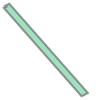

In [10]:
dataframe.iloc[0].geometry

# Utility functions
A mixed set of functions to deal with geospatial imagery.

In [28]:
def mask_to_rgb(mask: np.ndarray, palette:dict) -> np.ndarray:
    """Given an input batch, or single picture with dimensions [B, H, W] or [H, W], the utility generates
    an equivalent [B, H, W, 3] or [H, W, 3] array corresponding to an RGB version.
    The conversion uses the given palette, which should be provided as simple dictionary of indices and tuples, lists
    or arrays indicating a single RGB color. (e.g. {0: (255, 255, 255)})

    :param mask: input mask of indices. Each index should be present in the palette
    :type mask: np.ndarray
    :param palette: dictionary of pairs <index - color>, where colors can be provided in RGB tuple format
    :type palette: Dict[int, Iterable]
    :return: tensor containing the RGB version of the input index tensor
    :rtype: np.ndarray
    """
    lut = np.zeros((256, 3), dtype=np.uint8)
    for index, color in palette.items():
        lut[index] = np.array(color, dtype=np.uint8)
    return lut[mask]

In [29]:
def get_intersections(raster: rio.DatasetReader, panels: gpd.GeoDataFrame, group_by: str) -> Dict[str, list]:
    """Returns a dictionary of intersecting panels, grouped by panel category.

    Args:
        raster (rio.DatasetReader): raster image as dataset format
        panels (gpd.GeoDataFrame): panel dataframe containing a geometry field
        group_by (str): name of the column to use for grouping (category, plant_id,...)

    Returns:
        Dict[str, list]: dictionary of <group_by: list(polygons)>
    """
    # create a dict where the default value is an empty list
    polygons = defaultdict(list)
    bounds = geom.box(*raster.bounds)
    # iterate polygons and store the ones intersecting with the raster bounds, grouped by panel category
    for _, row in panels.iterrows():
        if bounds.intersects(row.geometry):
            intersection = bounds.intersection(row.geometry)
            if isinstance(intersection, geom.MultiPolygon):
                intersection = list(intersection)
                polygons[row[group_by]].extend(intersection)
            else:
                polygons[row[group_by]].append(intersection)
    return polygons


In [30]:
def project(shape: geom.Polygon, from_crs: pyproj.CRS, to_crs: pyproj.CRS = pyproj.CRS(3857)) -> geom.Polygon:
    """Projects the given shape from `from_crs` to `to_crs`, which defaults to pseudo-mercator.

    Args:
        shape (geom.Polygon): shape to be projected
        from_crs (pyproj.CRS): source CRS
        to_crs (pyproj.CRS, optional): destination CRS. Defaults to pyproj.CRS(3857).

    Returns:
        geom.Polygon: reprojected shape
    """
    projection = pyproj.Transformer.from_crs(from_crs, to_crs, always_xy=True).transform
    return ops.transform(projection, shape)


In [31]:
def box_dimensions(shape: geom.Polygon, crs: pyproj.CRS, resolution: float = 1.0) -> Tuple[int, int]:
    """Returns the dimension of the image containing the given shape, with the specified resolution in pixels/m.

    Args:
        shape (geom.Polygon): input shape
        crs (pyproj.CRS): input CRS
        resolution (float, optional): Resolution in pixels/m. Defaults to 1.0.

    Returns:
        Tuple[int, int]: height and width of the resulting raster.
    """
    if crs != pyproj.CRS(3857):
        mercator_shape = project(shape, from_crs=crs)
    else:
        mercator_shape = shape
    minx, miny, maxx, maxy = mercator_shape.bounds
    resx, resy = resolution if isinstance(resolution, tuple) else (resolution, resolution)
    return np.ceil(np.abs(maxx - minx) / resx), np.ceil(np.abs(maxy - miny) / resy)


In [32]:
def crop(raster: rio.DatasetReader, polygons: List[geom.Polygon], min_size: int = 256, padding: Union[tuple, int] = 16) -> Any:
    """Crops the given raster into a rasterio Window containing the given polygons, also padded by the specified amount.

    Args:
        raster (rio.DatasetReader): input raster image in rasterio format
        polygons (List[geom.Polygon]): list of polygons insersecting the image
        min_size (int, optional): minimum crop size for each side, in pixels. Defaults to 256.
        padding (Union[tuple, int], optional): padding for each side, in pixels. Defaults to 16.

    Returns:
        Window: rasterio Window of the crop
    """
    padx, pady = padding if isinstance(padding, tuple) else (padding, padding)
    window = rio.features.geometry_window(raster, polygons, pad_x=padx, pad_y=pady)

    h = max(window.height, min_size)
    w = max(window.width, min_size)
    if h > window.height or w > window.width:
        centroid = geom.MultiPolygon(polygons).centroid
        px, py = src.index(centroid.x, centroid.y)
        window = rio.windows.Window(py - np.ceil(h/2), px - np.ceil(w/2), h, w)
    return window


In [33]:
def store_window(source: rio.DatasetReader, destination: Any, window: rio.windows.Window) -> None:
    """Wrapper around rasterio open and write.

    Args:
        source (rio.DatasetReader): input source to be written
        destination (Any): output file to write into
        window (rio.windows.Window): window to be used to read from the source
    """
    metadata = source.meta.copy()
    metadata.update({
        "height": window.height,
        "width": window.width,
        "transform": rio.windows.transform(window, source.transform)
    })
    with destination.open(**metadata) as dataset:
        dataset.write(source.read(window=window))


In [35]:
def tile_overlapped(image: np.ndarray, tile_size: Union[tuple, int] = 256, channels_first: bool = False) -> np.ndarray:
    """Generates a set of tiles with dynamically computed overlap, so that every tile is contained inside the image
    bounds.

    Args:
        image (np.ndarray): input image to be tiled.
        tile_size (Union[tuple, int], optional): size of the tile in pixels, assuming a square tile. Defaults to 256.
        channels_first (bool, optional): whether the image has CxHxW format or HxWxC. Defaults to False.

    Raises:
        ValueError: when the image is smaller than a single tile

    Returns:
        np.ndarray: numpy array with shape num_tilesH X num_tilesW x tileH x tileW x channels
    """
    if len(image.shape) == 2:
        axis = 0 if channels_first else -1
        image = np.expand_dims(image, axis=axis)
    if channels_first:
        image = np.moveaxis(image, 0, -1)
    # assume height, width, channels from now on
    height, width, channels = image.shape
    tile_h, tile_w = tile_size if isinstance(tile_size, tuple) else (tile_size, tile_size)
    if height <= tile_h and width <= tile_w:
        raise ValueError("Image is smaller than the required tile size")
    # number of expected tiles
    tile_count_h = int(np.ceil(width / tile_h))
    tile_count_w = int(np.ceil(height / tile_w))
    # compute total remainder for the expanded window
    remainder_h = (tile_count_h * tile_h) - height
    remainder_w = (tile_count_w * tile_w) - width
    # divide remainders among tiles as overlap (floor to keep overlap to the minimum)
    overlap_h = int(np.floor(remainder_h / float(tile_count_h - 1))) if tile_count_h > 1 else 0
    overlap_w = int(np.floor(remainder_w / float(tile_count_w - 1))) if tile_count_w > 1 else 0
    # create the empty tensor to contain tiles
    tiles = np.empty((tile_count_h, tile_count_w, tile_h, tile_w, channels), dtype=image.dtype)
    for row in range(tile_count_h):
        for col in range(tile_count_w):
            # get the starting indices, accounting from initial positions
            x = max(row * tile_h - overlap_h, 0)
            y = max(col * tile_w - overlap_w, 0)
            # if it exceeds horizontally or vertically in the last rows or cols, increase overlap to fit
            if (x + tile_h) >= height:
                x -= abs(x + tile_h - height)
            if (y + tile_w) >= width:
                y -= abs(y + tile_w - width)
            # assign tile to final tensor
            tiles[row, col] = image[x:x + tile_h, y:y + tile_w, :]
    return tiles

# Tiling tests
Given that grid splits don't work out quite well, the current procedure to extrapolate panels is the following:
 - group panels by plant ID
 - for each raster image:
   - for each plant and list of polygons:
     - check if the group overlap with the current image
     - crop the group with a minimum size for height and width
     - divide in fixed tiles if one dimension is bigger than the fixed tile size

In [36]:
# gather the 105 images from Alessandria and Asti
raster_tiles = list(glob.glob(str(settings.raster_folder / "*.tif")))
#assert len(raster_tiles) == 105

# get the CRS from the first image
with rio.open(raster_tiles[0], driver="GTiff") as src:
    raster_crs = src.crs
str(raster_crs)

'EPSG:32632'

In [37]:
# reproject panels to be in the same reference system
dataframe = dataframe.to_crs(str(raster_crs))
str(dataframe.crs)

'EPSG:32632'

# Store tiles to file
Iterate on the whole set and save the generated tiles into a folder, defined in the settings.

In [38]:
def store_raster(filename: Path, data: np.ndarray, count: int, channels_first: bool = False, **metadata) -> None:
    """Stores a numpy array as GeoTIFF

    Args:
        filename (Path): absolute or relative path to the image file (/mnt/folder/filename.tif)
        data (np.ndarray): data to be stored as CxHxW or HxWxC whether it is channels first or not
        count (int): number of channels (e.g. RGBIR = 4)
        channels_first (bool, optional): true when input has format CxHxW. Defaults to False.
    """
    # rasterio wants channels first
    if not channels_first:
        data = np.moveaxis(data, -1, 0)
    # create the new file and save data
    with rio.open(filename, mode="w", driver="GTiff", count=count, **metadata) as dst:
        dst.write(data)

# Data preparation for Detectron2
This loop provides sub-images (with size 512x512) - extracted from the source image - and panel information. Only images with panels are considered. The panel information is stored in a json file. The structure of the json file is created by looking at the ballon dataset used in Detectron2.


In [21]:
def store_window_to_file(source: Any, destination: Any) -> None:
    """Wrapper around rasterio open and write.

    Args:
        source (Any): input source to be written
        destination (Any): output file to write into
    """
    profile = source.profile
    profile.update(
        dtype=rio.uint8,
        count=4, height=512, width=512)

    with rio.open(destination, 'w', **profile) as dst:
        dst.write(source.read())

In [22]:
def windowing(source, tile_size=(512, 512)):

    # assume height, width, channels from now on
    height, width = source.height, source.width
    tile_h, tile_w = tile_size if isinstance(tile_size, tuple) else (tile_size, tile_size)
    
    if height <= tile_h and width <= tile_w:
        raise ValueError("Image is smaller than the required tile size")
    # number of expected tiles
    tile_count_h = int(np.ceil(width / tile_h))
    tile_count_w = int(np.ceil(height / tile_w))
    # compute total remainder for the expanded window
    remainder_h = (tile_count_h * tile_h) - height
    remainder_w = (tile_count_w * tile_w) - width

    # divide remainders among tiles as overlap (floor to keep overlap to the minimum)
    overlap_h = int(np.floor(remainder_h / float(tile_count_h - 1))) if tile_count_h > 1 else 0
    overlap_w = int(np.floor(remainder_w / float(tile_count_w - 1))) if tile_count_w > 1 else 0

    # create the empty tensor to contain tiles
    out = []
    for row in range(tile_count_h):
        for col in range(tile_count_w):
            # get the starting indices, accounting from initial positions
            x = max(row * tile_h - overlap_h, 0)
            y = max(col * tile_w - overlap_w, 0)
            # if it exceeds horizontally or vertically in the last rows or cols, increase overlap to fit
            if (x + tile_h) >= height:
                x -= abs(x + tile_h - height)
            if (y + tile_w) >= width:
                y -= abs(y + tile_w - width)
            
            coords = (row, col)
            window = rio.windows.Window(col_off=x, row_off=y, width=tile_w, height=tile_h)
            out+=[(coords, window)]
            
            # assign tile to final tensor
            #tiles[row, col] = image[x:x + tile_h, y:y + tile_w, :]
    return out

In [23]:
def data_creation(tile):

    #prcs_tiles = [x.replace(".json", "") for x in os.listdir(settings.window_folder/"json")]
    result = dict()
    tile_id = os.path.splitext(os.path.basename(tile))[0]

    if not os.path.isfile(settings.window_folder/Path("json/"+tile_id+".json")):
        f = open("windows_list.txt", "a+")
        f.write(str(settings.window_folder/Path("json/"+tile_id+".json\n")))
        f.close()
        with rio.open(tile, driver="GTiff") as src:       
            for coords, window in windowing(src):          
                with rio.io.MemoryFile() as tmp:
                    store_window(src, tmp, window=window)
                    with tmp.open(driver="GTiff") as window_src:
                        intersections = get_intersections(window_src, dataframe, group_by="category")
                        if intersections:
                            window_id = tile_id + f"_{coords[0]}_{coords[1]}"
                            result[window_id] = dict()
                            result[window_id]["fileref"] = ""
                            result[window_id]["size"] = 262144
                            result[window_id]["filename"] = window_id+".tif"           
                            result[window_id]["base64_img_data"] = ""
                            result[window_id]["file_attributes"] = dict()
                            result[window_id]["regions"] = dict()

                            if not os.path.isfile(settings.window_folder/Path(window_id+".tif")):
                                store_window_to_file(window_src, settings.window_folder/Path(window_id+".tif"))

                            for category, panels in intersections.items():
                                for index, panel in enumerate(panels):
                                    panel_mask, _ = rio.mask.mask(window_src, [panel], crop=False, indexes=1)        
                                    coords = np.argwhere(panel_mask > 0)
                                    coords_x = coords[:,1]
                                    coords_y = coords[:,0]
                                    if (len(coords_x)+len(coords_y))<5: #at least 6 pixels to have a polygon
                                        print("Coordinates are not available -", window_id, index, "- lenght", (len(coords_x)+len(coords_y)))
                                        continue

                                    result[window_id]["regions"][str(index)] = {
                                        "shape_attributes": { 
                                            "name": "polygon",
                                            "category": settings.class2index[category],
                                            "all_points_x": coords_x.tolist(),
                                            "all_points_y": coords_y.tolist()},
                                        "region_attributes": {}}                                      
        if len(result)!=0:
            with open(settings.window_folder/Path("json/"+tile_id+".json"), "w") as file:
                    json.dump(result, file)
                    prcs_tiles = len(os.listdir(settings.window_folder/"json"))
                    print(tile_id, "saved. - ", prcs_tiles, "with panles.")

In [24]:
import multiprocessing as mp
pool = mp.Pool(16)
results = pool.map(data_creation, [tile for tile in raster_tiles])
pool.close()

In [99]:
unified_json = dict()
for j in os.listdir(settings.window_folder/"json"):
    with open(settings.window_folder/"json"/j) as json_file:
        data = json.load(json_file)
        if len(data) != 0:
            unified_json.update(data)

with open(settings.window_folder/'metadata.json', 'w') as outfile:
    json.dump(unified_json, outfile)
    print("metadata.txt created")

metadata.txt created


## Training-Validation Split 

In [110]:
from PIL import Image

def data_creation(metadata, data_type, split_value):

    _json = dict()
    if not os.path.isdir(settings.data_folder/data_type):
        os.makedirs(settings.data_folder/data_type)

    for idx, v in enumerate(metadata.values()):
        filename = os.path.join(settings.window_folder, v["filename"])
        _json[v["filename"].replace(".tif", "")] = dict()
        
        with rio.open(filename, driver="GTiff") as src:
            im_np = src.read()[:-1].transpose(1,2,0)
            im = Image.fromarray(im_np)
            im.save(settings.data_folder/data_type/v["filename"].replace(".tif", ".jpg"))
            v["filename"] = v["filename"].replace(".tif", ".jpg")
            _json[v["filename"].replace(".jpg", "")].update(v)

    print(
        f"{data_type} dataset lenght: {len(metadata.values())} - {round(split_value*100)}%"
        )
    with open(settings.data_folder/data_type/Path(data_type+".json"), "w") as outfile:
        json.dump(_json, outfile)


def train_test_split(metadata, split_value):

    # random shuffle
    meta_list = list(metadata.items())
    random.shuffle(meta_list)
    metadata = dict(meta_list)
    print("Total lenght:", len(metadata))
    # train-val split
    metadata_train = dict(list(metadata.items())[:round(len(metadata)*split_value)])
    metadata_val = dict(list(metadata.items())[round(len(metadata)*split_value):])
    # data creation
    data_creation(metadata_train, "train", split_value)
    data_creation(metadata_val, "val", 1-split_value)



In [112]:
with open(settings.window_folder/"metadata.json") as json_file:
        metadata = json.load(json_file)

train_test_split(metadata, split_value=0.95)

Total lenght: 759
721 38
train dataset lenght: 721 - 95%
val dataset lenght: 38 - 5%


In [5]:
#!pip install torch==1.8.1+cu102 torchvision==0.9.1+cu102 torchaudio===0.8.1 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.8/index.html


In [4]:
import torch, torchvision
assert torch.__version__.startswith("1.8.1")   # need to manually install torch 1.8 if Colab changes its default version
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

print(torch.__version__, torch.cuda.is_available())

1.8.1+cu102 True


In [5]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_panels_dicts(img_dir):
    typ = os.path.basename(img_dir)
    json_file = os.path.join(img_dir, typ+".json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            category = anno["category"]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": int(category),
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("panels_" + d, lambda d=d: get_panels_dicts(settings.data_folder/d))
    MetadataCatalog.get("panels_" + d).set(thing_classes=["_","Mono","Poli"]) #bkg: background, M:Mono cristallino, P: Poli cristallino
panels_metadata = MetadataCatalog.get("panels_train")


  0%|          | 0/5 [00:00<?, ?it/s]

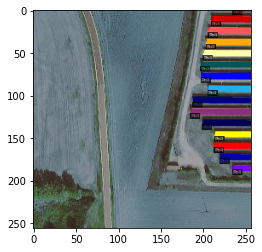

 20%|██        | 1/5 [00:00<00:01,  3.25it/s]

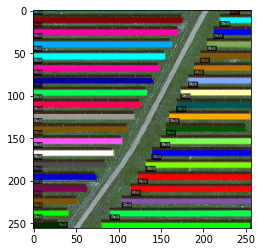

 40%|████      | 2/5 [00:00<00:01,  2.76it/s]

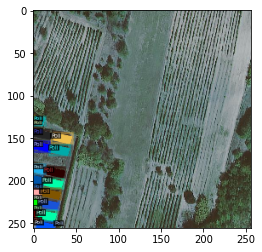

 60%|██████    | 3/5 [00:01<00:00,  2.96it/s]

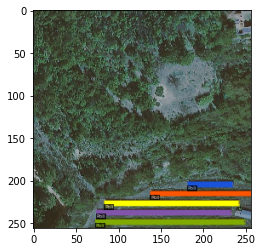

 80%|████████  | 4/5 [00:01<00:00,  3.13it/s]

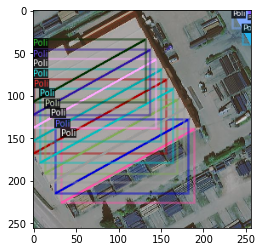

100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


In [6]:
dataset_dicts = get_panels_dicts(settings.data_folder/"train")
for d in tqdm(random.sample(dataset_dicts, 5)):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=panels_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [11]:
from detectron2.engine import DefaultTrainer

torch.cuda.set_device(5)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("panels_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 3
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 500    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
#cfg.INPUT.MASK_FORMAT="bitmask"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/29 10:37:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

RuntimeError: DataLoader worker (pid 1243494) exited unexpectedly with exit code 1. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [8]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

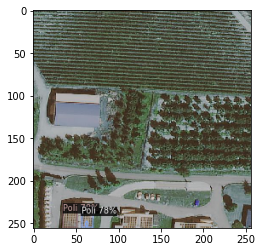

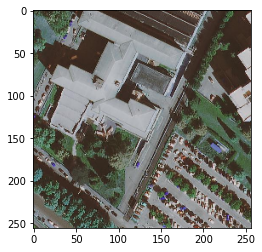

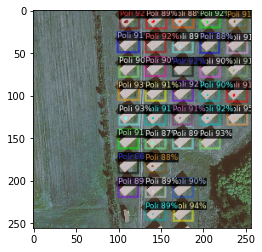

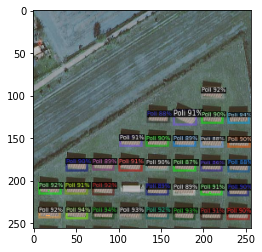

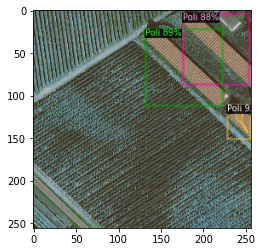

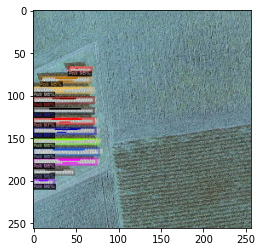

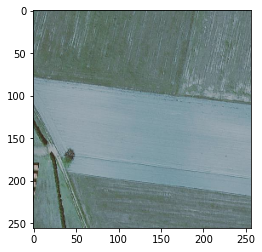

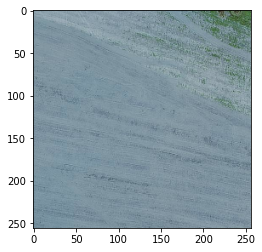

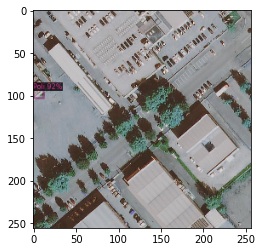

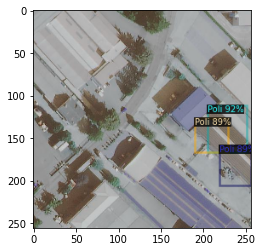

In [9]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_panels_dicts(settings.data_folder/"val")
for d in random.sample(dataset_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=panels_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [11]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("panels_val", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "panels_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[06/29 10:13:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/29 10:13:48 d2.data.common]: Serializing 38 elements to byte tensors and concatenating them all ...
[06/29 10:13:48 d2.data.common]: Serialized dataset takes 6.30 MiB
[06/29 10:13:48 d2.evaluation.evaluator]: Start inference on 38 images
[06/29 10:13:49 d2.evaluation.evaluator]: Inference done 11/38. 0.0413 s / img. ETA=0:00:01
[06/29 10:13:51 d2.evaluation.evaluator]: Total inference time: 0:00:02.212591 (0.067048 s / img per device, on 1 devices)
[06/29 10:13:51 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.041595 s / img per device, on 1 devices)
[06/29 10:13:51 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/29 10:13:51 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[06/29 10:13:51 d2.evaluation.coco_evaluation]